In [ ]:
import pandas as pd
import wooldridge
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import matplotlib.pyplot as plt

In [2]:
# Load the 'intdef' dataset
df = wooldridge.data('intdef')

# Set the year as the index for plotting
df.index = pd.to_datetime(df['year'], format='%Y')

# Let's look at the two series: 3-month T-bill rate (i3) and inflation (inf)
print(df[['i3', 'inf']].head())

              i3  inf
year                 
1948-01-01  1.04  8.1
1949-01-01  1.10 -1.2
1950-01-01  1.22  1.3
1951-01-01  1.55  7.9
1952-01-01  1.77  1.9


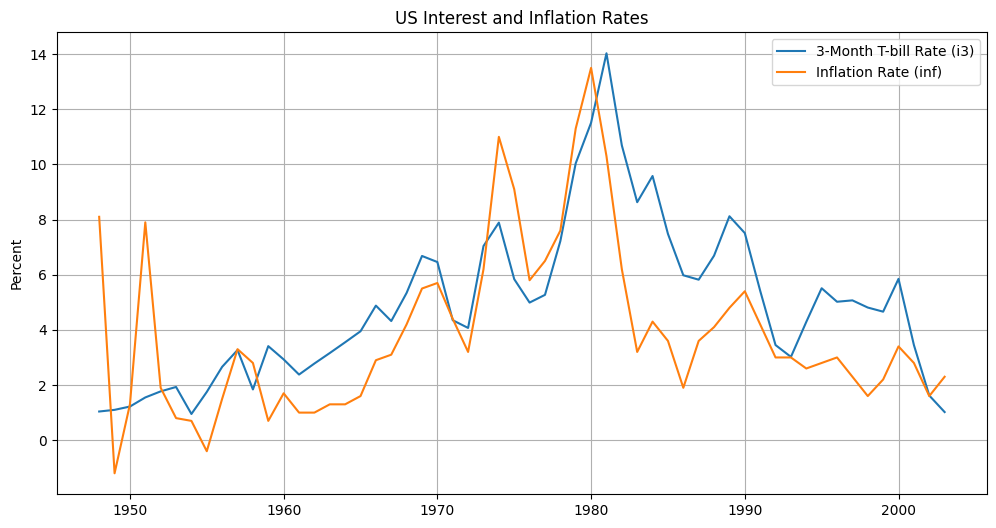

In [3]:
# Plot the series to visualize them
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['i3'], label='3-Month T-bill Rate (i3)')
plt.plot(df.index, df['inf'], label='Inflation Rate (inf)')
plt.title('US Interest and Inflation Rates')
plt.ylabel('Percent')
plt.legend()
plt.grid(True)
plt.show()

### Engle-Granger two-step method 

In [ ]:
## Step 1: Test for Unit Roots in Individual Series
# Perform ADF test on i3
adf_i3 = adfuller(df['i3'])
print(f'ADF Test for i3 (Interest Rate):')
print(f'  Test Statistic: {adf_i3[0]:.4f}')
print(f'  p-value: {adf_i3[1]:.4f}') # High p-value -> Fail to reject H0

# Perform ADF test on inf
adf_inf = adfuller(df['inf'])
print(f'\nADF Test for inf (Inflation):')
print(f'  Test Statistic: {adf_inf[0]:.4f}')
print(f'  p-value: {adf_inf[1]:.4f}') # High p-value -> Fail to reject H0

ADF Test for i3 (Interest Rate):
  Test Statistic: -1.7794
  p-value: 0.3907

ADF Test for inf (Inflation):
  Test Statistic: -1.7459
  p-value: 0.4077


In [7]:
## Step 2: Test for Cointegration

# Perform the Engle-Granger Cointegration Test
# We test if i3 and inf are cointegrated
coint_test_result = coint(df['i3'], df['inf'])

print('Engle-Granger Cointegration Test Results:')
print(f'  Test Statistic: {coint_test_result[0]:.4f}')
print(f'  p-value: {coint_test_result[1]:.4f}')
print('  Critical Values:')
print(f'    1%: {coint_test_result[2][0]:.4f}')
print(f'    5%: {coint_test_result[2][1]:.4f}')
print(f'   10%: {coint_test_result[2][2]:.4f}')

Engle-Granger Cointegration Test Results:
  Test Statistic: -4.0503
  p-value: 0.0061
  Critical Values:
    1%: -4.1066
    5%: -3.4495
   10%: -3.1225


Estimated Equilibrium Error (First 5 values):
year
1948-01-01   -6.568867
1949-01-01   -0.551646
1950-01-01   -2.033049
1951-01-01   -5.930755
1952-01-01   -1.867386
dtype: float64


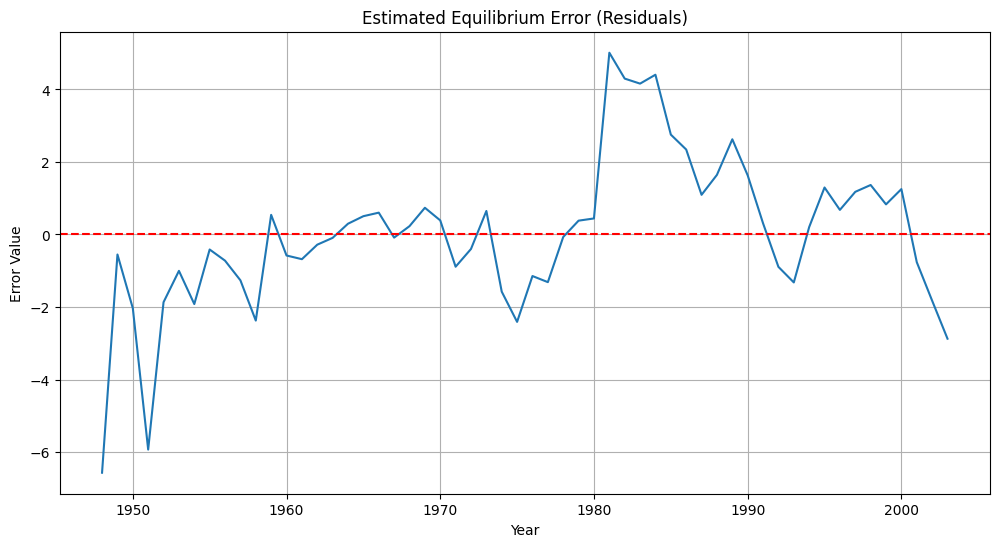

In [8]:
## Step 3: Equilibrium error

# Define dependent (y) and independent (x) variables
y = df['i3']
X = df['inf']

# Add a constant (intercept) to the regression model
X = sm.add_constant(X)

# 1. Estimate the long-run relationship with OLS
long_run_model = sm.OLS(y, X).fit()

# 2. Extract the residuals, which are the equilibrium error
equilibrium_error = long_run_model.resid

# Display the first few values of the equilibrium error
print("Estimated Equilibrium Error (First 5 values):")
print(equilibrium_error.head())

# Plot the equilibrium error
plt.figure(figsize=(12, 6))
plt.plot(equilibrium_error.index, equilibrium_error)
plt.axhline(0, color='red', linestyle='--') # Add a line at zero
plt.title('Estimated Equilibrium Error (Residuals)')
plt.ylabel('Error Value')
plt.xlabel('Year')
plt.grid(True)
plt.show()

In [9]:
#  Common trends: Stock and Watson (1988).

# Define our variables
# Y is the dependent variable (i3)
# X is the independent variable (inf), with a constant added
Y = df['i3']
X = sm.add_constant(df['inf'])

# Run the OLS regression to find the cointegrating parameters
model = sm.OLS(Y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     i3   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     46.19
Date:                Wed, 30 Jul 2025   Prob (F-statistic):           8.81e-09
Time:                        15:20:31   Log-Likelihood:                -120.66
No. Observations:                  56   AIC:                             245.3
Df Residuals:                      54   BIC:                             249.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4203      0.463      5.224      0.0

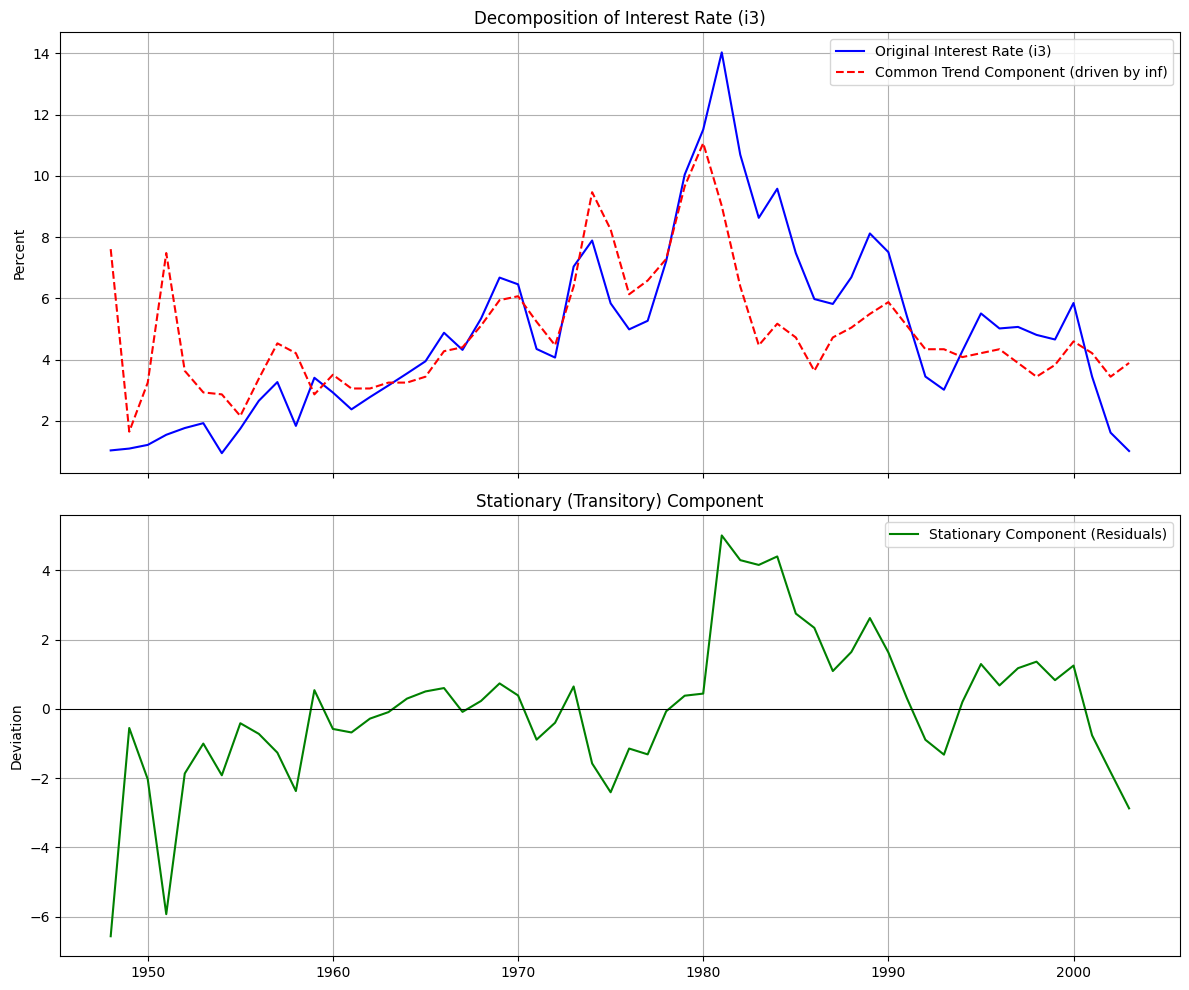

ADF test p-value on residuals: 0.0013


In [10]:
# Add the components to our DataFrame
df['common_component'] = model.fittedvalues
df['stationary_component'] = model.resid

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Top Plot: Original Series vs. Common Component ---
ax1.plot(df.index, df['i3'], label='Original Interest Rate (i3)', color='blue')
ax1.plot(df.index, df['common_component'], label='Common Trend Component (driven by inf)', linestyle='--', color='red')
ax1.set_title('Decomposition of Interest Rate (i3)')
ax1.set_ylabel('Percent')
ax1.legend()
ax1.grid(True)

# --- Bottom Plot: Stationary Component ---
ax2.plot(df.index, df['stationary_component'], label='Stationary Component (Residuals)', color='green')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.75)
ax2.set_title('Stationary (Transitory) Component')
ax2.set_ylabel('Deviation')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# We can also formally test the stationary component (residuals) again
adf_residuals = adfuller(df['stationary_component'])
print(f'ADF test p-value on residuals: {adf_residuals[1]:.4f}')